In [1]:
import os
from dotenv import load_dotenv
while not os.getcwd().endswith("llm_agents"):
    os.chdir("..")
print(os.getcwd())

load_dotenv();
%load_ext autoreload
%autoreload 2

/Users/cristian/Personal/Projects/llm_agents


# Aperitech - LLM Agents: LangChain and LangGraph


## What is LangChain?

Langchain is a framework for developing and building applications powerd by large language models. As the name suggests, it allow to build a workflow as a chain of modular operations that can be executed in sequence or in parallel. The framework provides a common interface for:
- Prompting
- Information retrieval
- Interacting with language models, supporting also chatbot-like interactions
- Structuring the LLM output
- Persistence of interactions
- Tool management
- Orchestration

![alt text](https://python.langchain.com/svg/langchain_stack_112024_dark.svg)

   

## What is LangGraph?


LangGraph is a graph-based library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. As a very low-level framework, it provides fine-grained control over both the flow and state of your application, crucial for creating reliable agents. Additionally, LangGraph includes built-in persistence, enabling advanced human-in-the-loop and memory features. I can be used both as a standalone library or as a part of LangChain. among its features:
- `Cycles` and Branching: Implement loops and conditionals in your apps.
- `Persistence`: Automatically save state after each step in the graph. Pause and resume the graph execution at any point to support error recovery, human-in-the-loop workflows, time travel and more.
- `Human-in-the-Loop`: Interrupt graph execution to approve or edit next action planned by the agent.
- `Streaming Support`: Stream outputs as they are produced by each node (including token streaming).


### Why LangGraph?

LLMs are extremely powerful, particularly when connected to other systems such as a retriever or APIs.
Often a control flow of steps before and / or after an LLM is called a "chain." Chains are a popular paradigm for programming with LLMs and offer a high degree of reliability; the same set of steps runs with each chain invocation.

However, we often want LLM systems that can pick their own control flow! This is one definition of an `agent`: an agent is a system that uses an LLM to decide the control flow of an application. Unlike a chain, an agent gives an LLM some degree of control over the sequence of steps in the application. Rather than a fixed sequence of steps, an agent can decide which steps to take based on the output of the LLM. This includes:

- Routing between two potential paths
- Deciding which of many tools to call
- Is the generated answer sufficient or more work is needed?
  

### Agent Architectures

There are different types of agent architecrures to consider, giving the LLM different degrees of control over the application. On one extreme, a router allow an LLM to select a single step from a list of fixed options. On the other extreme, a fully autonomous agent gives the LLM full freedom to select any sequence of steps it want to solve a given problem. In between, there are many other shade of of gray.

![alt text](https://langchain-ai.github.io/langgraph/concepts/img/agent_types.png)

Desplite the chosen architecture, there are some common concepts that are shared by all agents:
- `Tool calling`: the agent can call tools not only to perform specific tasks but also to make decisions.
- `Action selection`: the agent can select the next action to take based on the output of the LLM.
- `Memory`: the agent can store information between steps or between different interactions with the user.
- `Planning`: the agent can plan a sequence of actions to achieve a goal.

In practice, there is often a trade-off between control and reliability. The more control the LLM has over the application, the less reliable it is. This can be due to the LLM making mistakes, non-determinism in the environment, or other factors. The goal of `LangGraph` is to help to bend the curve preserving higher reliability as we give the agent more control over the application.
![alt text](https://langchain-ai.github.io/langgraph/concepts/img/langgraph.png)

### Graph Components

At its core, LangGraph models the agent workflows as graphs. You define the behavior of your agents using three key components:
1. `State`: a shared data structure that represents the current snapshot of the application.
2. `Nodes`: Python functions that encode the logic of your agents. They receive the current State as input (or a subset of the State), perform some computation or side-effect, and return an updated State. `They do the actual work`.
3. `Edges`: Python functions that determine which Node to execute next based on the current State. They can be conditional branches or fixed transitions. They tell the agent `what to do next`.

**How does it work?**

The underlying graph algorithm, uses the `message passing` paradigm to define a general program. When a Node completes its operation, it sends a message along one or more edges to other node(s). These receiving nodes then execute their functions, pass the resulting message to the next set of nodes, and so on.
A single iteration over the graph nodes is called a `super-step`. Nodes that runs in parallel are part of the same super-step, whereas nodes that run in sequence are part of different super-steps.
At the beginning of the execution, all nodes start in an `inactive` state. After receiving a message, a node becomes `active` then run its function and responds with updates. At the end of the super-step, nodes with no incoming messages vote to `halt` marking themselves as `inactive`.

To build a graph, you need first to define the `State`, then the `Nodes` and finally the `Edges`. You then create the graph with a `NetworkX` like style, and finally you compile and run the graph.

#### Workflow

The real power of the architecture comes from how LangGraph manages the State. The State consists of the schema of the graph as well as reducer functions specifying how to update the element of the State. The Schema can be defined either using `TypeDict` or a Pydantic `BaseModel`. 

**Multiple Schemas**

By default, the graph will have the same input and ouput schemas, however,there are cases where you might need more control over this, for example:
- Internal nodes can pass information that is not required in the graph's input/output
- We may want to use different input/output schemas for the graph. The output, might include only a subset of properties.

It is possible to have nodes write to private state channels inside the graph for internal node communication. We can simply define a private schema, PrivateState. See [this notebook](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) for more detail.

It is also possible to define explicit input and output schemas for a graph. In these cases, we define an "internal" schema that contains all keys relevant to graph operations. But, we also define input and output schemas that are sub-sets of the "internal" schema to constrain the input and output of the graph. See [this notebook](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/) for more detail.


**State Reducers**

Reducers are the key to understand how updates from nodes are applied to the State. Each property of the state has its own independent reducer function. If no reducer is defined, the default behavior is to replace the value of the property.

In [2]:
from typing import Annotated, Literal, Sequence

from langchain_core.messages import HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel
from IPython.display import Image, display

In [3]:
# Every time a node updates the state, the whole list of messages
# will be replaced with the new one.
class AgentStateNoReducerFunction(BaseModel):
    """State of an agent with no reducer function"""
    messages: Sequence[BaseMessage]

# The presence of a reducer function allows allow the agend to:
# - Append the new messages if they have different ids
# - Update the previous messages if they have the same id
# This allow a more efficient management of the state
class AgentState(BaseModel):
    """State of an agent with a reducer function"""
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Building a Simple Graph-based Agent
We will now build a simple graph-based agent that takes as input a user request and calls a tool to generate the answer.


#### 1. Initialize the model and tools
We use `ChatOpenAI` as our LLM. To make sure the model knows it has some available tools, we need to convert the `LangChain` tools into the `OpenAI` tool calling format with `.bind_tools()`.

[Here](https://python.langchain.com/docs/how_to/custom_tools/) you can find more information on how to create custom tools.

In [4]:
# Define the tools the agent can use
@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

# Tools are threated as a list of functions
tools = [search]

# Initialize a ChatOpenAI instance
model_name = 'gpt-4o'
temperature = 0.
model = ChatOpenAI(model=model_name, temperature=temperature).bind_tools(tools)

#### 2. Define the State
We use a simple Pydantic BaseModel that contains a sequence of BaseMessage objects, with the appropriate reducer function.

In [5]:
class AgentState(BaseModel):
    """State of an agent with a reducer function"""
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### 3. Define the Nodes of the graph
There are two main nodes we need:

- The `agent node`: responsible for deciding what (if any) actions to take.
- The `tools node` that invokes tools: if the agent decides to take an action, this node will then execute that action.

In [6]:
# Define the function that calls the model
def call_model(state: AgentState) -> AgentState:
    response = model.invoke(state.messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# To define the tool node, we can rely on the ToolNode class
tool_node = ToolNode(tools)

#### 4. Define entry point and graph edges.
First, we need to set the entry point for graph execution - agent node.

Then we define one normal and one conditional edge. Conditional edge means that the destination depends on the contents of the graph's state (AgentState). In our case, the destination is not known until the agent (LLM) decides.

Conditional edge: after the agent is called, we should either:
- a. Run tools if the agent said to take an action, OR
- b. Finish (respond to the user) if the agent did not ask to run tools

Normal edge: after the tools are invoked, the graph should always return to the agent to decide what to do next

In [7]:
# Define the function that determines whether to continue or not
def should_continue(state: AgentState) -> Literal["tools", END]:
    messages = state.messages
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

#### 5. Compile and run the graph
To make the graph executable, we need to compile it. This will create a LangChain `Runnable` that can be invoked with the input data.

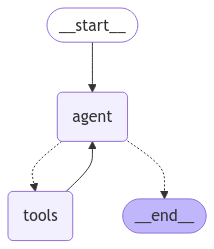

In [8]:
# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
app = workflow.compile()

# To display the graph, we can use the `draw_mermaid_png` method
display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

#### 6. Execute the graph
The workflow is the following:
1. LangGraph adds the input message to the internal state, then passes the state to the entrypoint node, `"agent"`.
2. The `"agent"` node executes, invoking the chat model.
3. The chat model returns an `AIMessage`. LangGraph adds this to the state.
4. Graph cycles the following steps until there are no more `tool_calls` on `AIMessage`:
    - If `AIMessage` has `tool_calls`, `"tools"` node executes
    - The `"agent"` node executes again and returns `AIMessage`
Execution progresses to the special `END` value and outputs the final state. And as a result, we get a list of all our chat messages as output.

In [10]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="what is the weather in Milan?")]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

'The current weather in Milan is 90 degrees and sunny.'

### Agent with Structured Output
You might want your agent to return its output in a structured format. For example, if the output of the agent is used by some other downstream software, you may want the output to be in the same structured format every time the agent is invoked to ensure consistency. Basically, there are two different options to reach this goal:
1. Add a tool for structuring the output
2. Set an explicit post-processing step in the graph

Both of the options will use the same graph structure as shown in the diagram below, but will have different mechanisms under the hood.
![alt text](./images/structured_output_graph.png)

#### Option 1: Add a tool for structuring the output
The first way you can force your tool calling agent to have structured output is to bind the output you would like as an additional tool for the agent node to use. In contrast to the basic ReAct agent, the agent node in this case is not selecting between tools and END but rather selecting between the specific tools it calls. Then, among these tools there might be one or more tools responsable for structuring the output and deciding where to route the output (either ending the execution or moving to the next step).

![alt text](./images/structured_output_tool.png)

**Pros:**
The benefit to this format is that you only need one LLM, and can save money and latency because of this. The agent can be more flexible in its output, and can be more easily modified to have different output structures.

**Cons:**
The downside to this option is that it isn't guaranteed that the single LLM will call the correct tool when you want it to. We can help the LLM by setting `tool_choice` to `any` when we use `bind_tools` which forces the LLM to select at least one tool at every turn, but this is far from a fool proof strategy. In addition, another downside is that the agent might call multiple tools, so we need to check for this explicitly in our routing function (or if we are using OpenAI we an set `parallell_tool_calling=False` to ensure only one tool is called at a time).

An important note is the necessity of adding another response node to answer the user and provide the actual structured output. The idea is that, despite the agent can use a BaseModel as a tool, the actual answer will be a serialized object, whose parameters are are all strings. To convert this to an actual Object, we add this step that takes the arguments of that function call and return the object itself.

This is the reason why the two graph structure are the same.

### Option 2: Explicit post-process
The second way you can force your tool calling agent to have structured output is to use a second LLM (in this case `model_with_structured_output`) to parse the output of the first LLM.

![alt text](./images/structured_output_postprocess.png)
In this case, you will define a basic ReAct agent normally, but instead of having the agent node choose between the tools node and ending the conversation, the agent node will choose between the tools node and the respond node. The respond node will contain a second LLM that uses structured output, and once called will return directly to the user. You can think of this method as basic ReAct with one extra step before responding to the user.

**Pros:**
The benefit of this method is that it guarantees structured output (as long as `.with_structured_output` works as expected with the LLM).

**Cons:**
On the other hand, using this approach requires an additional LLM call before responding to the user, meaning additional cost and latency. 
Moreover, if the `agent` LLM (the one using tools) is not aware of the desired output schema, there is the risk that the agent LLM will fail to call the correct tools to generate the desired output. This can be mitigated with appropriate prompting and tool selection strategies, at the cost of increasing again the cost and latency of the system.

Let us explore an example. First we define how we want to structure our output, define our graph state, and also our tools and the models we are going to use. To use structured output, we will use the with_structured_output method from LangChain, which you can read more about [here](https://python.langchain.com/docs/how_to/structured_output/).

We are going to use a single tool in this example for finding the weather, and will return a structured weather response to the user.

In [11]:
from typing import Annotated, Literal, Sequence
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages


# Define the BaseModel that will be used as the structured output
class WeatherResponse(BaseModel):
    """Respond to the user with this"""
    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(
        description="The direction of the wind in abbreviated form"
    )
    wind_speed: float = Field(description="The speed of the wind in km/h")

class BaseState(BaseModel):
    """Base state of the agent"""
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Define the state of the agent
class AgentState(BaseState):
    """ State of the agent"""
    # Final structured response from the agent
    final_response: WeatherResponse | None = Field(
        description="The final response from the agent",
        default=None,
    )
    

@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It is cloudy in NYC, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "sf":
        return "It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")


# Define the tools the agent can use
tools = [get_weather]

# Initialize a ChatOpenAI instance
model = ChatOpenAI(model="gpt-4o", temperature=0.0)

### Option 1: Add a tool for structuring the output
The graph definition is very similar to the one above, the only difference is we no longer call an LLM in the `response` node, and instead bind the `WeatherResponse` tool to our LLM that already contains the `get_weather` tool.


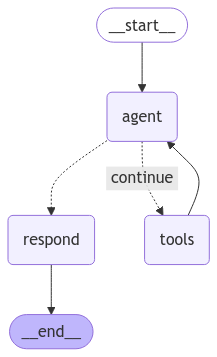

In [12]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# We can simply use the BaseModel we defined earlier as a tool for the structured output
tools = [get_weather, WeatherResponse]

# Force the model to use tools by passing tool_choice="any"
model_with_response_tool = model.bind_tools(tools, tool_choice="any")


# Define the function that calls the model.
# This represent the agent node
def call_model(state: BaseState):
    response = model_with_response_tool.invoke(state.messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
# This perform the actual parsing of the response, taking the parameters to initialize
# the base model from the arguments of the last tool call
def respond(state: BaseState):
    # Construct the final answer from the arguments of the last tool call
    response = WeatherResponse(**state.messages[-1].tool_calls[0]["args"])
    # We return the final answer
    return {"final_response": response}


# Define the function that determins the conditional logic of the agent.
def should_continue(state: BaseState):
    messages = state.messages
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if (
        len(last_message.tool_calls) == 1
        and last_message.tool_calls[0]["name"] == "WeatherResponse"
    ):
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [13]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})[
    "final_response"
]
answer

WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=4.82803)

### Option 2: Explicit post-process
Let's now dive into how we would use a second LLM to force structured output.


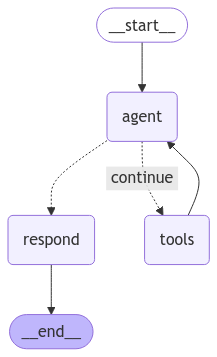

In [14]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage


# Define the tools the agent can use
tools = [get_weather]

# The difference with respect to previouse example is that here we do not
# need to force the agent to use the tools. Therefore, no need to use `tool_choice="any"`
model_with_tools = model.bind_tools(tools)
model_with_structured_output = model.with_structured_output(WeatherResponse)

# Define the function that calls the model.
# This represent the agent node
def call_model(state: BaseState):
    response = model_with_tools.invoke(state.messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function that responds to the user
def respond(state: BaseState):
    # Here, the respond node call another LLM, this time with structured output
    # in order to return the same format to the user every time.
    # We could have sent the entire chat history, sending just the `state.messages[-2]` saves tokens.
    # The reason we use `state.messages[-2]` is because:
    # state.messages[-1] is the response from the first model, wheras state.messages[-2] is the last ToolMessage
    response = model_with_structured_output.invoke(
        [HumanMessage(content=state.messages[-2].content)]
    )
    # We return the final answer
    return {"final_response": response}


# Define the function that determines whether to continue or not
def should_continue(state: BaseState):
    messages = state.messages
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [15]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})[
    "final_response"
]
answer

WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=4.82803)

### How to debug?
`LangSmith` is a platform for building production-grade LLM applications. It allows you to monitor and evaluate your application, visualizing the message exchange with the LLMs. If interested, you can find more information [here](https://python.langchain.com/docs/how_to/debugging/).

The main drawback of using LangSmith is that it is not free. It has a free-tier, but for more advanced features you will need to pay. An open-source alternative is [LangFuse](https://github.com/langfuse/langfuse). It presents a similar interface providing a completely free self-hosted solution and a cloud-based solution with a larger free-tier, compared to LangSmith.

In [17]:
from langfuse.callback import CallbackHandler
langfuse_handler = CallbackHandler()
config = {'callbacks': [langfuse_handler]}

answer = graph.invoke(
    input={"messages": [("human", "what's the weather in SF?")]},
    config=config,
)[
    "final_response"
]
answer

WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=4.82803)